In [1]:
import datetime 
import numpy as np
import pandas as pd
from tqdm import tqdm
import plotly.express as px
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

### Data
<l>focusing on bitcoin<l>

In [303]:
data = pd.read_csv("g-research-crypto-forecasting/train.csv")
data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [3]:
#summary stat
data.describe()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423680e+07,2.348647e+07
mean,1.577120e+09,6.292544e+00,2.864593e+02,1.432640e+03,1.436350e+03,1.429568e+03,1.432640e+03,2.868530e+05,NaN,7.121752e-06
std,3.323350e+07,4.091861e+00,8.673982e+02,6.029605e+03,6.039482e+03,6.020261e+03,6.029611e+03,2.433935e+06,NaN,5.679042e-03
min,1.514765e+09,0.000000e+00,1.000000e+00,1.170400e-03,1.195000e-03,2.000000e-04,1.171400e-03,-3.662812e-01,-inf,-5.093509e-01
25%,1.549011e+09,3.000000e+00,1.900000e+01,2.676500e-01,2.681600e-01,2.669000e-01,2.676483e-01,1.410725e+02,2.676368e-01,-1.694354e-03
50%,1.578372e+09,6.000000e+00,6.400000e+01,1.428860e+01,1.431250e+01,1.426300e+01,1.428920e+01,1.295415e+03,1.428769e+01,-4.289844e-05
75%,1.606198e+09,9.000000e+00,2.210000e+02,2.288743e+02,2.293000e+02,2.284200e+02,2.288729e+02,2.729764e+04,2.288728e+02,1.601520e-03
max,1.632182e+09,1.300000e+01,1.650160e+05,6.480594e+04,6.490000e+04,6.467053e+04,6.480854e+04,7.597554e+08,inf,9.641699e-01


In [4]:
data.isna().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

In [304]:
bitcoin_df = data[data['Asset_ID']==1].reset_index(drop=True)

### Feature Extraction from date

</l> timestamp to datetime </l>

In [305]:
bitcoin_df['datetime'] = pd.to_datetime(bitcoin_df['timestamp'],unit='s')
bitcoin_df

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,datetime
0,1514764860,1,229.0,13835.194000,14013.800000,13666.11,13850.176000,31.550062,13827.062093,-0.014643,2018-01-01 00:01:00
1,1514764920,1,235.0,13835.036000,14052.300000,13680.00,13828.102000,31.046432,13840.362591,-0.015037,2018-01-01 00:02:00
2,1514764980,1,528.0,13823.900000,14000.400000,13601.00,13801.314000,55.061820,13806.068014,-0.010309,2018-01-01 00:03:00
3,1514765040,1,435.0,13802.512000,13999.000000,13576.28,13768.040000,38.780529,13783.598101,-0.008999,2018-01-01 00:04:00
4,1514765100,1,742.0,13766.000000,13955.900000,13554.44,13724.914000,108.501637,13735.586842,-0.008079,2018-01-01 00:05:00
...,...,...,...,...,...,...,...,...,...,...,...
1956277,1632182160,1,1940.0,42983.780000,43001.850849,42878.26,42899.012857,56.850913,42935.489499,NaN,2021-09-20 23:56:00
1956278,1632182220,1,2026.0,42904.197143,42932.000000,42840.16,42860.005714,80.993326,42879.576084,NaN,2021-09-20 23:57:00
1956279,1632182280,1,1986.0,42859.385714,42887.500000,42797.20,42827.020000,65.677734,42844.090693,NaN,2021-09-20 23:58:00
1956280,1632182340,1,4047.0,42839.012802,43042.160000,42818.10,43017.277143,138.335477,42935.761938,NaN,2021-09-20 23:59:00


### Visualization

In [ ]:
fig = go.Figure([go.Scatter(x=bitcoin_df['datetime'], y=bitcoin_df['Close'])])
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
    xaxis_title="date",
    yaxis_title="close price"
)
# fig.show()
fig.write_html("Closing_price.html", auto_open = False)


In [11]:
fig = go.Figure([go.Scatter(x=bitcoin_df['datetime'], y=bitcoin_df['Volume'])])
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
    paper_bgcolor="LightSteelBlue",
    xaxis_title="date",
    yaxis_title="Volume"
)
# fig.show()
fig.write_html("Volume_price.html", auto_open = False)


### Feature Engineering

<l> pct_change: percentage change between the current and a prior element. </l>

<l> log return: measure the rate of exponential growth  </l>

<l> Minutes: convert minutes in sin cos form


In [6]:
bitcoin_df["pct_change"] = bitcoin_df.Close.pct_change()
bitcoin_df["log_return"] = np.log(bitcoin_df.Close) - np.log(bitcoin_df.Close.shift(1))
bitcoin_df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,datetime,pct_change,log_return
0,1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643,2018-01-01 00:01:00,NaN,NaN
1,1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037,2018-01-01 00:02:00,-0.001594,-0.001595
2,1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309,2018-01-01 00:03:00,-0.001937,-0.001939
3,1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999,2018-01-01 00:04:00,-0.002411,-0.002414
4,1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079,2018-01-01 00:05:00,-0.003132,-0.003137
5,1514765160,1,554.0,13717.714,14000.7,13520.00,13717.112,70.805776,13706.952030,-0.004422,2018-01-01 00:06:00,-0.000568,-0.000569
6,1514765220,1,546.0,13720.922,14001.4,13501.01,13670.940,70.762103,13683.843336,-0.008873,2018-01-01 00:07:00,-0.003366,-0.003372
7,1514765280,1,437.0,13669.246,13914.6,13504.99,13721.348,78.298555,13701.600413,-0.008492,2018-01-01 00:08:00,0.003687,0.003680
8,1514765340,1,288.0,13713.412,13948.9,13539.99,13720.260,60.100796,13720.524584,-0.006282,2018-01-01 00:09:00,-0.000079,-0.000079
9,1514765400,1,270.0,13713.610,13948.5,13530.00,13719.902,56.578007,13711.904983,-0.003889,2018-01-01 00:10:00,-0.000026,-0.000026


In [7]:
btc_mini = bitcoin_df.iloc[:-200]

In [8]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, 
                                    open=btc_mini['Open'], 
                                    high=btc_mini['High'], 
                                    low=btc_mini['Low'], 
                                    close=btc_mini['Close'])])
fig.show()


### Preprocessing 

<l> Handling Outlier (missing variable)

#ตรงนี้ยังไม่ได้ทำ แค่เอาข้อมูลตัวอย่างมา 100 rows

In [15]:
bitcoin_df.head(100).isna().sum()

timestamp     0
Asset_ID      0
Count         0
Open          0
High          0
Low           0
Close         0
Volume        0
VWAP          0
Target        0
datetime      0
pct_change    1
log_return    1
dtype: int64


<l> Minutes-> Minutes in Sin & Cos <l>

<li> to balance distribution of data </li>


In [306]:
date = []
minute_sin = []
minute_cos = []
for i in tqdm(bitcoin_df["datetime"]):
    cdate = datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S')
    minute_sin.append(np.sin(2 * np.pi * cdate.minute/60.0))
    minute_cos.append(np.cos(2 * np.pi * cdate.minute/60.0))
bitcoin_df['mins_sin'] = minute_sin
bitcoin_df['mins_cos'] = minute_cos

100%|██████████| 1956282/1956282 [00:14<00:00, 137543.25it/s]


In [13]:
bitcoin_df['mins_sin'].min(), bitcoin_df['mins_sin'].max()

(-1.0, 1.0)

In [14]:
bitcoin_df['mins_sin'].min(), bitcoin_df['mins_sin'].max()

(-1.0, 1.0)

## Stationary or not

### 1. Augmented Dickey-Fuller(ADF) test


<li> Firstly, we assume that data is "Non-stationary". Then we do the test to reject "NULL HYPOTHESIS" </li> 


Critical value:  The cut-off values that define regions where the test statistic is unlikely to lie

ADF_statistic < Critical value

P-value(significance level) < 0.05


<img src="null.png" alt="Alternative text" />

In [15]:
from statsmodels.tsa.stattools import adfuller

adf_statistic, p_value, usedlag, _, critical_values, c  = adfuller(bitcoin_df["Close"].head(100).values, autolag='AIC')
print(f'ADF Statistic: {adf_statistic :.2f}')
print('p-value: %f' % p_value)
print('Critial Values:')

for key, value in critical_values.items():
    print('\t%s: %.3f' % (key, value))

if (p_value <= 0.05) & (critical_values['5%'] > adf_statistic):
    print("\u001b[32mStationary\u001b[0m")
else:
    print("\x1b[31mNon-stationary\x1b[0m")

ADF Statistic: -3.78
p-value: 0.003157
Critial Values:
	1%: -3.498
	5%: -2.891
	10%: -2.583
Stationary


### 2. Autocorrelation Function (ACF) & Partial Autocorrelation Function (PACF)


<li>Autocorrelation is the correlation between a time series with a lagged version of itself (starts at a lag of 0).</li>




<li> The partial autocorrelation at lag k is the autocorrelation between X_t_t and X_(t-k) that is not accounted for by lags 1 through 𝑘−1. </li>

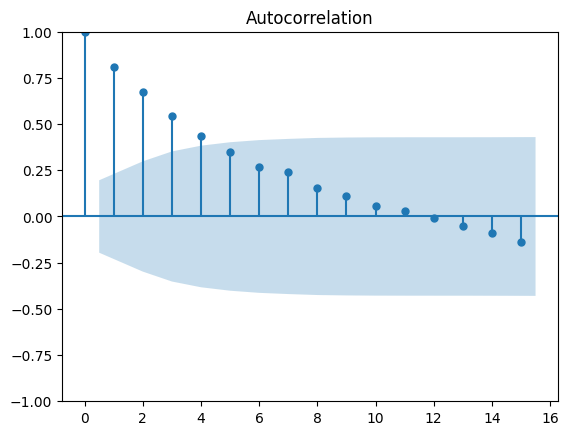

In [16]:
sm.graphics.tsa.plot_acf(bitcoin_df["Close"].head(100).values.squeeze(), lags=15)
plt.show()

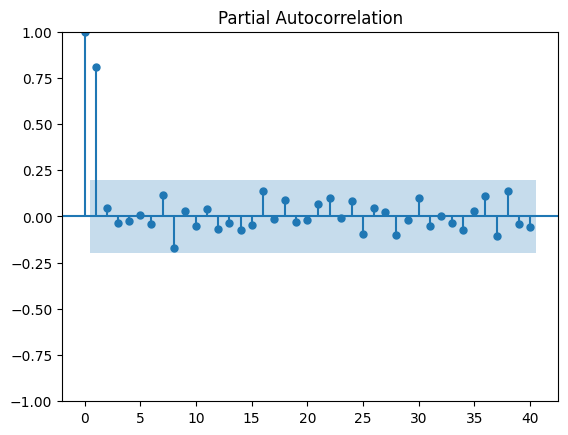

In [17]:
sm.graphics.tsa.plot_pacf(bitcoin_df["Close"].head(100).values.squeeze(), lags=40, method="ywm")
plt.show()

From two graph above, the ACF and PACF plots,  which depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.

### Is there a Seasonality

<li>Trend and seasonality can cause a time series to not be stationary</li>

<l>**Seasonality:** A recurring pattern that happens in short-term cycle at a fixed frequency.

**Trend:** Long-term increase or decrease in data of a time series</l>

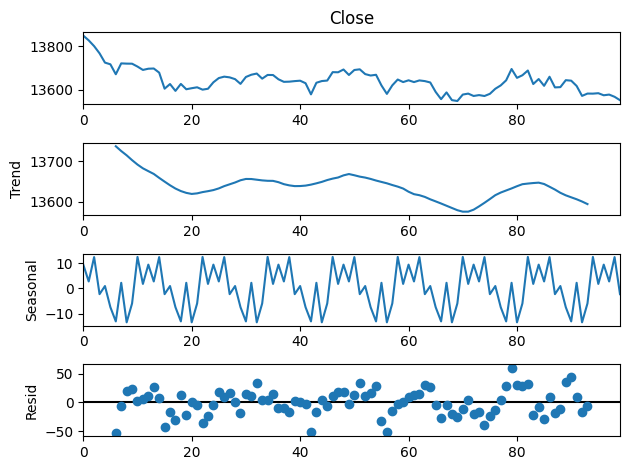

In [18]:
#seasonal decomposition using moving average
sd = seasonal_decompose(bitcoin_df["Close"].head(100), model="additive", period=12).plot()


### Feature Selection

<l> ตัวไหนคือตัวที่สำคัญ relate กับ Close "Open High Low"

<li> Correlation matrix</li>
<li>Univariate Selection</li>

### Correlation

In [307]:
df = bitcoin_df.copy()

In [308]:
df = df.drop(["Asset_ID"], axis=1)

In [309]:
#shift data (t-1) to predict data time t
input = df.shift(-1, axis=0)
input = input.drop(['Close'], axis=1)
# input

In [310]:
#present data at time t
output = bitcoin_df["Close"].copy()

In [311]:
input["diff"] = input["High"] - input["Low"]

In [439]:
analyst_df = pd.concat([output, input], axis=1).dropna()

In [14]:
analyst_df.corr()

/var/folders/10/t0kfxm0n0fnbdpv3zsc8ck2w0000gn/T/ipykernel_16288/2229136004.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  analyst_df.corr()


,Close,timestamp,Count,Open,High,Low,Volume,VWAP,Target,mins_sin,mins_cos,diff
Close,1.000000e+00,0.713430,0.522973,1.000000,0.999995,0.999995,0.044065,9.999993e-01,-0.008594,1.666202e-06,-8.585265e-07,0.298169
timestamp,7.134301e-01,1.000000,0.464925,0.713430,0.713013,0.713890,0.064911,7.134330e-01,-0.001806,-3.156777e-06,-1.255393e-05,0.059395
Count,5.229726e-01,0.464925,1.000000,0.522967,0.523879,0.521886,0.672700,5.229202e-01,-0.005641,1.648870e-02,1.415962e-02,0.504645
Open,9.999999e-01,0.713430,0.522967,1.000000,0.999995,0.999995,0.044059,9.999994e-01,-0.008596,1.742775e-06,-1.083609e-06,0.298162
High,9.999946e-01,0.713013,0.523879,0.999995,1.000000,0.999985,0.044804,9.999952e-01,-0.008617,1.739511e-05,1.435282e-05,0.300852
Low,9.999950e-01,0.713890,0.521886,0.999995,0.999985,1.000000,0.043127,9.999958e-01,-0.008595,-1.794755e-05,-1.311354e-05,0.295646
Volume,4.406482e-02,0.064911,0.672700,0.044059,0.044804,0.043127,1.000000,4.400944e-02,0.014201,1.410858e-02,1.462743e-02,0.306622
VWAP,9.999993e-01,0.713433,0.522920,0.999999,0.999995,0.999996,0.044009,1.000000e+00,-0.008607,4.170011e-07,-6.195286e-07,0.298138
Target,-8.594414e-03,-0.001806,-0.005641,-0.008596,-0.008617,-0.008595,0.014201,-8.606643e-03,1.000000,2.075476e-04,-7.223095e-04,-0.006272
mins_sin,1.666202e-06,-0.000003,0.016489,0.000002,0.000017,-0.000018,0.014109,4.170011e-07,0.000208,1.000000e+00,5.668975e-06,0.006186


Text(0.5, 1.0, 'Correlation of close price')

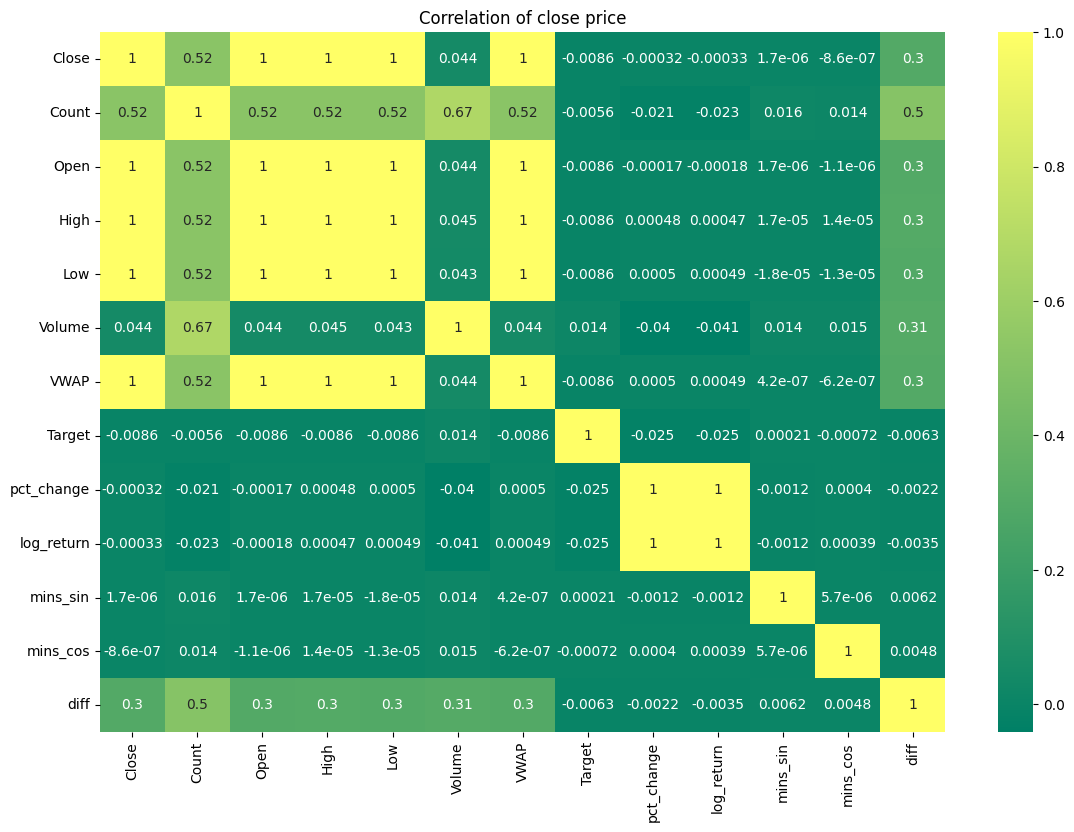

In [28]:
import seaborn as sns

plt.figure(figsize=(30, 20))

plt.subplot(2, 2, 1)
sns.heatmap(analyst_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of close price')


### Univariate Selection

pca

### Moving average

#### <li> Simple Moving Average (SMA) </li>

In [455]:
def calculate_moving_avg(df, window_size):
    # Create an empty list to store the moving averages
    sma_values = []

    # Iterate over the DataFrame column
    for i in range(len(df["Close"])):
        if i < window_size:
            # If index is less than window size, calculate average of the current window
            avg = df["Close"].iloc[:i+1].mean()
        else:
            # If index is greater than or equal to window size, calculate average of the current window
            avg = df["Close"].iloc[i-window_size+1:i+1].mean()

        sma_values.append(avg)
    # Add the moving averages as a new column to the DataFrame
    df['sma_' + str(window_size)] = sma_values

    return df

In [456]:
#moving avg
window_size = 10
analyst_df_10 = calculate_moving_avg(analyst_df, window_size)

In [457]:
#moving avg
window_size = 50
analyst_df_50 = calculate_moving_avg(analyst_df, window_size)

In [458]:
#moving avg
window_size = 200
analyst_df_200 = calculate_moving_avg(analyst_df, window_size)

### Moving average comparing with original close price

In [459]:
analyst_df

,Close,timestamp,Count,Open,High,Low,Volume,VWAP,Target,datetime,mins_sin,mins_cos,diff,ema_5,ema_20,ema_100,sma_10,sma_50,sma_200
0,13850.176000,1.514765e+09,235.0,13835.03600,14052.30,13680.00,31.046432,13840.362591,-0.015037,2018-01-01 00:02:00,0.207912,0.978148,372.30,13842.818000,13848.073714,13849.738891,13850.176000,13850.176000,13850.176000
1,13828.102000,1.514765e+09,528.0,13823.90000,14000.40,13601.00,55.061820,13806.068014,-0.010309,2018-01-01 00:03:00,0.309017,0.951057,399.40,13828.983333,13843.620408,13848.779982,13839.139000,13839.139000,13839.139000
2,13801.314000,1.514765e+09,435.0,13802.51200,13999.00,13576.28,38.780529,13783.598101,-0.008999,2018-01-01 00:04:00,0.406737,0.913545,422.72,13808.668889,13836.422274,13847.181171,13826.530667,13826.530667,13826.530667
3,13768.040000,1.514765e+09,742.0,13766.00000,13955.90,13554.44,108.501637,13735.586842,-0.008079,2018-01-01 00:05:00,0.500000,0.866025,401.46,13780.750593,13825.802438,13844.760039,13811.908000,13811.908000,13811.908000
4,13724.914000,1.514765e+09,554.0,13717.71400,14000.70,13520.00,70.805776,13706.952030,-0.004422,2018-01-01 00:06:00,0.587785,0.809017,480.70,13759.537728,13815.450968,13842.232355,13794.509200,13794.509200,13794.509200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956259,42769.395714,1.632181e+09,3329.0,42760.10875,42841.99,42600.00,109.043573,42710.292966,0.001714,2021-09-20 23:39:00,-0.809017,-0.587785,241.99,43552.975064,43527.583892,43753.008378,42691.294058,43062.749660,43520.376370
1956260,42637.115000,1.632181e+09,2643.0,42632.46500,42736.90,42607.50,100.797218,42653.031385,0.002084,2021-09-20 23:40:00,-0.866025,-0.500000,129.40,43558.933509,43531.704511,43749.401290,42689.047317,43045.403474,43514.663481
1956261,42703.636250,1.632181e+09,2281.0,42718.81500,42819.38,42690.84,76.339988,42755.785162,0.003246,2021-09-20 23:41:00,-0.913545,-0.406737,128.54,43523.887578,43524.284626,43743.547714,42699.371317,43032.118485,43509.427482
1956262,42781.970571,1.632181e+09,2642.0,42772.92125,42827.10,42690.75,117.429123,42749.075916,0.003108,2021-09-20 23:42:00,-0.951057,-0.309017,136.35,43486.923623,43513.685682,43737.002130,42715.140374,43021.423446,43504.631049


In [81]:
analyst_df_mini = analyst_df.iloc[-200:]

In [82]:
fig = go.Figure(data=[go.Candlestick(x=analyst_df_mini["datetime"], 
                                    open=analyst_df_mini['Open'], 
                                    high=analyst_df_mini['High'], 
                                    low=analyst_df_mini['Low'], 
                                    close=analyst_df_mini['Close'])])

#sma_10
# Create a line graph of the moving average
sma_10 = go.Scatter(
    x=analyst_df_mini["datetime"],
    y=analyst_df_mini['sma_10'],
    name='SMA 10',
    line=dict(width=2, color='blue')
)

sma_50 = go.Scatter(
    x=analyst_df_mini["datetime"],
    y=analyst_df_mini['sma_50'],
    name='SMA 50',
    line=dict(width=2, color='skyblue')
)

sma_200 = go.Scatter(
    x=analyst_df_mini["datetime"],
    y=analyst_df_mini['sma_200'],
    name='SMA 200',
    line=dict(width=2, color='purple')
)

fig.add_trace(sma_10)
fig.add_trace(sma_50)
fig.add_trace(sma_200)

fig.update_layout(title='Stock Price with Moving Averages',
                  xaxis_title='Date',
                  yaxis_title='Price')

fig.write_html("graph/simple_moving_average.html", auto_open = False)


#### <li> Exponential moving average (EMA) </li>

In [250]:
try:
    value = analyst_df.at[940592, 'Close']
    print("Index 940592 has a value:", value)
except KeyError:
    print("Index 940592 is null")

Index 940592 is null


In [258]:
analyst_df.Close.sort_values(ascending=True).head(10)

502059    3151.545000
501938    3153.762000
502060    3153.895714
502032    3155.047143
502028    3155.528333
502061    3156.633333
502062    3159.106667
502063    3159.328830
502020    3159.845714
502064    3159.860000
Name: Close, dtype: float64

In [244]:
analyst_df[analyst_df["Close"] == 0]

,Close,timestamp,Count,Open,High,Low,Volume,VWAP,Target,datetime,...,sma_50,sma_200,ema_5,ema_20,ema_100,Fast EMA,Slow EMA,MACD Line,Signal Line,Histogram


In [249]:
analyst_df["Close"].sort_values()

502059      3151.545000
501938      3153.762000
502060      3153.895714
502032      3155.047143
502028      3155.528333
               ...     
1726300    64667.455714
1726588    64682.405714
1726589    64731.851429
1726260    64744.321940
1726259    64808.537275
Name: Close, Length: 1955977, dtype: float64

In [424]:
def exponential_moving_average(df, window_size):
    ema_values = []
    k = 2 / (window_size + 1)
    if len(df["Close"]) > 0:
        ema_prev = df["Close"].iloc[0]
        if not pd.isnull(ema_prev):
            for i in range(1, len(df["Close"])):
                ema_current = df["Close"].iloc[i] * k + ema_prev * (1 - k)
                ema_prev = ema_current
                ema_values.append(ema_current)

    # df = df[:-1]

    # df["ema_" + str(window_size)] = ema_values
    
    return ema_values

In [445]:
def exponential_moving_average(df, window_size):
    ema_values = []
    k = 2 / (window_size + 1)
    if len(df["Close"]) > 0:
        ema_prev = df.get("Close").get(0)
        if ema_prev is not None:
            for i in range(1, len(df["Close"])):
                if i < window_size:
                    ema_current = df.get("Close").get(i, 0) * k + ema_prev * (1 - k)
                    ema_prev = ema_current
                else:
                    ema_current = df.get("Close").get(i, 0) * k + ema_prev * (1 - k)
                    ema_prev = ema_current
                ema_values.append(ema_current)
    #check for null values
    if len(ema_values) < len(df.index):
        missing_values = len(df.index) - len(ema_values)
        ema_values.extend([0] * missing_values)
    df['ema_' + str(window_size)] = ema_values
    return ema_values

In [450]:
#exponential moving avg
window_size = 5

ema_5 = exponential_moving_average(analyst_df, window_size)


In [452]:
#exponential moving avg
window_size = 20
ema_20 = exponential_moving_average(analyst_df, window_size)

In [438]:
[print(i) for i in ema_20 if i == 0]

[]

In [454]:
#exponential moving avg
window_size = 100
ema_100 = exponential_moving_average(analyst_df, window_size)

In [464]:
ema_analyst_df = analyst_df[:-1]

In [467]:
ema_analyst_df_mini = ema_analyst_df.iloc[-200:]

In [468]:
ema_analyst_df_mini

,Close,timestamp,Count,Open,High,Low,Volume,VWAP,Target,datetime,mins_sin,mins_cos,diff,ema_5,ema_20,ema_100,sma_10,sma_50,sma_200
1956063,43729.680000,1.632169e+09,1759.0,43728.342857,43751.00,43689.56,87.969132,43713.703943,-0.000462,2021-09-20 20:23:00,0.669131,-0.743145,61.44,43927.138026,43918.141611,43860.642008,43776.226406,43758.553212,43692.232539
1956064,43719.648571,1.632169e+09,1560.0,43723.342857,43748.00,43700.00,74.953882,43726.427884,-0.000581,2021-09-20 20:24:00,0.587785,-0.809017,48.00,43894.345350,43909.629077,43860.010681,43768.118978,43762.614134,43691.494202
1956065,43710.882857,1.632170e+09,2719.0,43718.933502,43764.04,43702.99,114.078976,43730.523078,-0.001466,2021-09-20 20:25:00,0.500000,-0.866025,61.05,43880.887734,43904.328450,43859.891114,43758.715692,43766.317619,43690.570302
1956066,43751.097143,1.632170e+09,2755.0,43757.057595,43799.04,43729.46,83.679466,43767.510298,-0.001403,2021-09-20 20:26:00,0.406737,-0.913545,69.58,43856.370572,43895.091098,43858.850423,43751.317370,43769.884219,43689.938637
1956067,43741.677143,1.632170e+09,2581.0,43741.107143,43770.00,43699.00,83.973132,43733.553816,-0.001981,2021-09-20 20:27:00,0.309017,-0.951057,71.00,43823.555604,43882.027723,43856.851913,43747.147084,43772.404887,43689.572844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956258,42736.652500,1.632181e+09,2303.0,42750.582857,42833.90,42731.17,89.168415,42781.237301,0.002059,2021-09-20 23:38:00,-0.743145,-0.669131,102.73,43537.469025,43521.646707,43756.422949,42684.399112,43079.669346,43525.335656
1956259,42769.395714,1.632181e+09,3329.0,42760.108750,42841.99,42600.00,109.043573,42710.292966,0.001714,2021-09-20 23:39:00,-0.809017,-0.587785,241.99,43552.975064,43527.583892,43753.008378,42691.294058,43062.749660,43520.376370
1956260,42637.115000,1.632181e+09,2643.0,42632.465000,42736.90,42607.50,100.797218,42653.031385,0.002084,2021-09-20 23:40:00,-0.866025,-0.500000,129.40,43558.933509,43531.704511,43749.401290,42689.047317,43045.403474,43514.663481
1956261,42703.636250,1.632181e+09,2281.0,42718.815000,42819.38,42690.84,76.339988,42755.785162,0.003246,2021-09-20 23:41:00,-0.913545,-0.406737,128.54,43523.887578,43524.284626,43743.547714,42699.371317,43032.118485,43509.427482


In [469]:
fig = go.Figure(data=[go.Candlestick(x=ema_analyst_df_mini["datetime"], 
                                    open=ema_analyst_df_mini['Open'], 
                                    high=ema_analyst_df_mini['High'], 
                                    low=ema_analyst_df_mini['Low'], 
                                    close=ema_analyst_df_mini['Close'])])

#sma_10
# Create a line graph of the moving average
ema_5 = go.Scatter(
    x=ema_analyst_df_mini["datetime"],
    y=ema_analyst_df_mini['ema_5'],
    name='EMA 5',
    line=dict(width=2, color='blue')
)

ema_20 = go.Scatter(
    x=ema_analyst_df_mini["datetime"],
    y=ema_analyst_df_mini['ema_20'],
    name='EMA 20',
    line=dict(width=2, color='skyblue')
)

ema_100 = go.Scatter(
    x=ema_analyst_df_mini["datetime"],
    y=ema_analyst_df_mini['ema_100'],
    name='EMA 100',
    line=dict(width=2, color='purple')
)

fig.add_trace(ema_5)
fig.add_trace(ema_20)
fig.add_trace(ema_100)

fig.update_layout(title='Stock Price with Exponential Moving Averages',
                  xaxis_title='Date',
                  yaxis_title='Price')

fig.write_html("graph/exponential_moving_average.html", auto_open = True)


#### <li> Moving Average Convergence Divergence (MACD) </li>

In [488]:
def calculate_macd(df):
    #short window
    ema_12 = exponential_moving_average(df, 12)
    #long window
    ema_26 = exponential_moving_average(df, 26)
    macd_line = [ema_12[i] - ema_26[i] for i in range(len(ema_12))]
    signal_line = exponential_moving_average(pd.DataFrame({'Close': macd_line}), 9)
    histogram = np.array(macd_line) - np.array(signal_line)

    df["Slow EMA"] = ema_26
    df["Fast EMA"] = ema_12
    df["macd_line"] = macd_line
    df["signal_line"] = signal_line
    df["MACD"] = histogram

    return df, ema_12, ema_26, macd_line, signal_line, histogram

In [489]:
df_macd, ema_12, ema_26, macd_line, signal_line, histogram = calculate_macd(analyst_df)

In [491]:
df_macd_visualize = df_macd[:-1]

In [492]:
macd_analyst_df_mini = df_macd_visualize.iloc[-200:]

In [493]:
fig = go.Figure(data=[go.Candlestick(x=macd_analyst_df_mini['datetime'], 
                                    open=macd_analyst_df_mini['Open'], 
                                    high=macd_analyst_df_mini['High'], 
                                    low=macd_analyst_df_mini['Low'], 
                                    close=macd_analyst_df_mini['Close'])])

#macd
# Create a line graph of the moving average
fast_ema = go.Scatter(
    x=macd_analyst_df_mini['datetime'],
    y=macd_analyst_df_mini['Fast EMA'],
    name='EMA 12',
    line=dict(width=2, color='blue')
)

slow_ema = go.Scatter(
    x=macd_analyst_df_mini['datetime'],
    y=macd_analyst_df_mini['Slow EMA'],
    name='EMA 26',
    line=dict(width=2, color='skyblue')
)

fig.add_trace(fast_ema)
fig.add_trace(slow_ema)

fig.update_layout(title='Stock Price with Moving Averages Convergence Divergence',
                  xaxis_title='Date',
                  yaxis_title='Price')

fig.write_html("graph/MACD.html", auto_open = True)